In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt

In [162]:
N = 10  # number of recent points to track

In [163]:
points = pd.read_csv("../data/flowchart-data/charting-m-points.csv", encoding='unicode_escape')

/Users/damien/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [164]:
points

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,NaN,False,False,False,False,False,False,1,1,1
1,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,2,0,0,0.0,0.0,15-0,1 (2),1,0,...,NaN,False,False,False,False,False,False,1,1,1
2,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,3,0,0,0.0,0.0,30-0,1 (3),1,0,...,1.0,False,False,False,True,False,False,1,1,1
3,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,4,0,0,0.0,0.0,40-0,1 (4),1,0,...,NaN,True,False,False,False,False,False,1,1,1
4,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,5,0,0,1.0,0.0,0-0,2 (1),1,0,...,1.0,False,False,False,False,True,False,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619642,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,247,2,2,4.0,3.0,0-40,46 (4),0,0,...,NaN,False,False,False,False,False,False,1,0,1
619643,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,248,2,2,5.0,3.0,0-0,47 (1),0,0,...,NaN,False,False,False,False,False,False,1,1,1
619644,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,249,2,2,5.0,3.0,15-0,47 (2),0,0,...,NaN,False,False,False,False,False,False,1,1,1
619645,19600529-M-Roland_Garros-F-Nicola_Pietrangeli-...,250,2,2,5.0,3.0,30-0,47 (3),0,0,...,NaN,False,False,False,False,False,False,1,1,1


### plan

go through each match and keep a column for who won each individual point. also who was serving for each point. so make a separate table out of this and then we can try making one with features for the last 10, etc.

oh also we should keep a column for who was in the match

In [165]:
trimmed = points[points["match_id"] > "1991"][["match_id", "PtWinner", "isSvrWinner"]]
trimmed["p1Win"] = trimmed["PtWinner"] == 1
trimmed["isSvrWinner"] = trimmed["isSvrWinner"] == 1
trimmed["p1Served"] = trimmed["p1Win"] == trimmed["isSvrWinner"]
del(trimmed["PtWinner"])

In [166]:
points_dict = trimmed.to_dict("records")
points_dict

[{'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': True,
  'p1Served': True},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': False,
  'p1Win': True,
  'p1Served': False},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': False,
  'p1Win': True,
  'p1Served': False},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': False,
  'p1Win': True,
  'p1Served': False},
 {'match_id': '20220713-M-Newport-R16-Andy_Murray-Max_Purcell',
  'isSvrWinner': True,
  'p1Win': False,
  'p1Served': 

In [167]:
current_match = ""
p1Win_p1Served = 0
p1Win_p2Served = 0
p2Win_p1Served = 0
p2Win_p2Served = 0
recent_p1Served = []
recent_p2Served = []

for p in points_dict:
  if p["match_id"] != current_match:
    p1Win_p1Served = 0
    p1Win_p2Served = 0
    p2Win_p1Served = 0
    p2Win_p2Served = 0
    recent_p1Served = [None] * N
    recent_p2Served = [None] * N
    current_match = p["match_id"]
  p["p1Win_p1Served"] = p1Win_p1Served
  p["p1Win_p2Served"] = p1Win_p2Served
  p["p2Win_p1Served"] = p2Win_p1Served
  p["p2Win_p2Served"] = p2Win_p2Served
  for i in range(1, N + 1):
    p[f"p1Served{i}"] = recent_p1Served[-i]
    p[f"p2Served{i}"] = recent_p2Served[-i]
  if p["p1Served"]:
    recent_p1Served.append(p["p1Win"])
    p1Win_p1Served += p["p1Win"]
    p2Win_p1Served += not p["p1Win"]
    recent_p1Served.pop(0)
  else:
    recent_p2Served.append(p["p1Win"])
    p1Win_p2Served += p["p1Win"]
    p2Win_p2Served += not p["p1Win"]
    recent_p2Served.pop(0)

In [168]:
recent = pd.DataFrame.from_dict(points_dict)
recent

,match_id,isSvrWinner,p1Win,p1Served,p1Win_p1Served,p1Win_p2Served,p2Win_p1Served,p2Win_p2Served,p1Served1,p2Served1,...,p1Served6,p2Served6,p1Served7,p2Served7,p1Served8,p2Served8,p1Served9,p2Served9,p1Served10,p2Served10
0,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,0,0,0,0,None,None,...,None,None,None,None,None,None,None,None,None,None
1,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,1,0,0,0,True,None,...,None,None,None,None,None,None,None,None,None,None
2,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,2,0,0,0,True,None,...,None,None,None,None,None,None,None,None,None,None
3,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,True,True,True,3,0,0,0,True,None,...,None,None,None,None,None,None,None,None,None,None
4,20220713-M-Newport-R16-Andy_Murray-Max_Purcell,False,True,False,4,0,0,0,True,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574313,19910125-M-Australian_Open-SF-Stefan_Edberg-Iv...,True,False,False,104,60,56,100,True,True,...,True,False,False,False,True,True,True,False,False,False
574314,19910125-M-Australian_Open-SF-Stefan_Edberg-Iv...,True,False,False,104,60,56,101,True,False,...,True,False,False,False,True,False,True,True,False,False
574315,19910125-M-Australian_Open-SF-Stefan_Edberg-Iv...,False,True,False,104,60,56,102,True,False,...,True,False,False,False,True,False,True,False,False,True
574316,19910125-M-Australian_Open-SF-Stefan_Edberg-Iv...,True,False,False,104,61,56,102,True,True,...,True,False,False,False,True,False,True,False,False,False


In [169]:
recent = recent.dropna(axis=0, how="any")

In [170]:
serve_agg = recent.groupby("match_id").max(["p1Win_p1Served", "p2Win_p1Served", "p1Win_p2Served", "p2Win_p2Served"])
serve_sums = serve_agg[["p1Win_p1Served", "p2Win_p1Served", "p1Win_p2Served", "p2Win_p2Served"]].sum()
(serve_sums[0] + serve_sums[3]) / sum(serve_sums)

0.6411768621213926

the serving player wins about 64% of the time, basically

In [171]:
SMOOTHING_POINTS = 50

win_pct = recent.copy()
win_pct["pct_p1Served"] = (win_pct["p1Win_p1Served"] + SMOOTHING_POINTS * 0.64) / (win_pct["p1Win_p1Served"] + win_pct["p2Win_p1Served"] + SMOOTHING_POINTS)
win_pct["pct_p2Served"] = (win_pct["p1Win_p2Served"] + SMOOTHING_POINTS * 0.36) / (win_pct["p1Win_p2Served"] + win_pct["p2Win_p2Served"] + SMOOTHING_POINTS)
del(win_pct["p1Win_p1Served"])
del(win_pct["p2Win_p1Served"])
del(win_pct["p1Win_p2Served"])
del(win_pct["p2Win_p2Served"])

if P2 serves, invert each variable to be from the perspective of P2

In [172]:
SAMPLE_ORDER = list(range(len(win_pct)))
np.random.shuffle(SAMPLE_ORDER)
win_pct_np = win_pct.iloc[:, 1:].to_numpy("float")[SAMPLE_ORDER]
server_wins = win_pct_np.copy()
server_wins[win_pct_np[:, 2] == 0] = 1 - server_wins[win_pct_np[:, 2] == 0][:, list(range(0, 3)) + list(range(3 + N, 3 + 2 * N)) + list(range(3, 3 + N)) + [4 + 2 * N, 3 + 2 * N]]

In [173]:
X = server_wins[:, 3:]
y = server_wins[:, 1]
[np.corrcoef(X[:, i], y)[0, 1] for i in range(2 + 2 * N)]

[0.01733403232513631,
 0.011732716906805532,
 0.017850438011539328,
 0.00868615755813957,
 0.012695107807021048,
 0.008467198347952657,
 0.011230827750632345,
 0.010615583054097193,
 0.013313690900721306,
 0.01051042412545108,
 0.014768359262491119,
 0.011291092346005496,
 0.014133139674518513,
 0.012148941288678288,
 0.012391268391931115,
 0.010057437350515116,
 0.014001852207553168,
 0.008858102394701682,
 0.01203217263647847,
 0.010746296832151562,
 0.08395332094208993,
 0.008700196375125585]

the first two are your accuracy with all the features. the middle two are your accuracy only knowing each player's win % so far on points they've served. the last two are your accuracy only knowing the outcomes of the last N points each player has served.

In [174]:
linear_seq = LinearRegression().fit(X[:400000], y[:400000])
linear_no_seq = LinearRegression().fit(X[:400000, 2 * N:], y[:400000])
linear_only_recent = LinearRegression().fit(X[:400000, :2 * N], y[:400000])
log_seq = LogisticRegression().fit(X[:400000], y[:400000])
log_no_seq = LogisticRegression().fit(X[:400000, 2 * N:], y[:400000])
log_only_recent = LogisticRegression().fit(X[:400000, :2 * N], y[:400000])

(
  np.mean(np.square(y[400000:] - linear_seq.predict(X[400000:, ]))),
  np.mean(np.square(y[400000:] - log_seq.predict_proba(X[400000:, ])[:, 1])),
  np.mean(np.square(y[400000:] - linear_no_seq.predict(X[400000:, 2 * N:]))),
  np.mean(np.square(y[400000:] - log_no_seq.predict_proba(X[400000:, 2 * N:])[:, 1])),
  np.mean(np.square(y[400000:] - linear_only_recent.predict(X[400000:, :2 * N]))),
  np.mean(np.square(y[400000:] - log_only_recent.predict_proba(X[400000:, :2 * N])[:, 1]))
)

(0.22727052593375613,
 0.22726452875052933,
 0.227292550916414,
 0.22728769935826465,
 0.2283089381802645,
 0.22830367805629156)

for comparison: your accuracy if you only know who serves

In [175]:
np.square((1 - np.mean(y[:400000]))) * np.mean(y[400000:]) + np.square(np.mean(y[:400000])) * (1 - np.mean(y[400000:]))

0.2289121674930379

In [158]:
np.mean(log_seq.predict_proba(X)[y == 1, 1]),\
np.mean(log_no_seq.predict_proba(X[:, 2 * N:])[y == 1, 1])

(0.6441615979158487, 0.6440712262341174)

[Text(0.5, 0, 'Prediction'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Predictions of Logistic Regression with Sequential Data on Lost Points')]

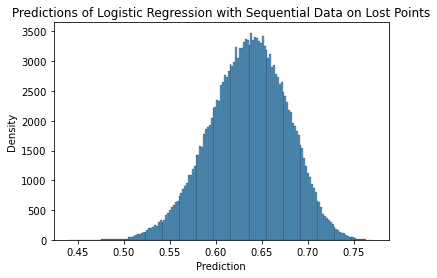

In [176]:
p = sns.histplot(log_seq.predict_proba(X)[y == 0, 1])
p.set(xlabel = 'Prediction', ylabel = 'Density', title="Predictions of Logistic Regression with Sequential Data on Lost Points")

[Text(0.5, 0, 'Prediction'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Predictions of Logistic Regression with Sequential Data on Won Points')]

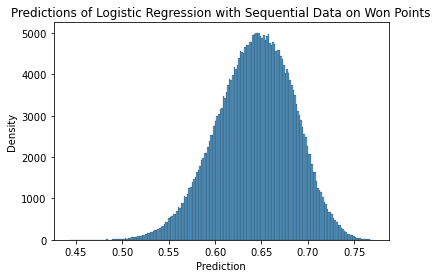

In [177]:
p = sns.histplot(log_seq.predict_proba(X)[y == 1, 1])
p.set(xlabel = 'Prediction', ylabel = 'Density', title="Predictions of Logistic Regression with Sequential Data on Won Points")

[Text(0.5, 0, 'Prediction'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Probability Densities for Linear Regression with Sequential Data')]

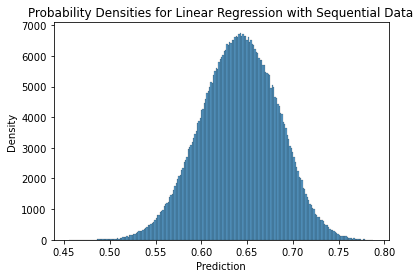

In [133]:
p = sns.histplot(linear_seq.predict(X))
p.set(xlabel = 'Prediction', ylabel = 'Density', title="Probability Densities for Linear Regression with Sequential Data")

[Text(0.5, 0, 'Prediction'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Probability Densities for Linear Regression without Sequential Data')]

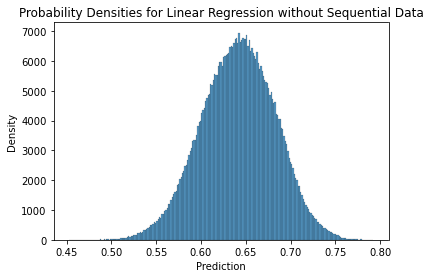

In [150]:
p = sns.histplot(linear_no_seq.predict(X[:, 2 * N:]))
p.set(xlabel = 'Prediction', ylabel = 'Density', title="Probability Densities for Linear Regression without Sequential Data")

<AxesSubplot:ylabel='Count'>

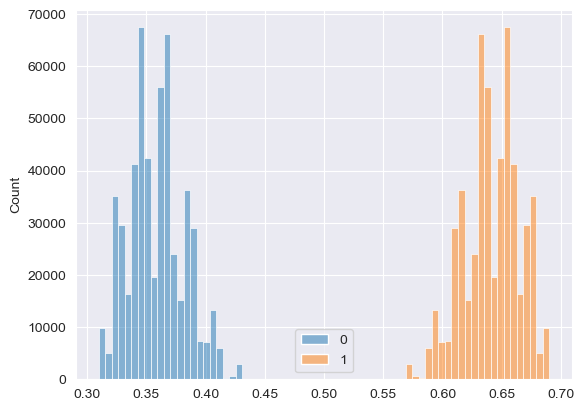

In [25]:
sns.histplot(log_only_recent.predict_proba(X[:,0:10]))

In [26]:
print(np.array2string(linear_seq.coef_, precision=5, suppress_small=True))

[0.00803 0.00919 0.00445 0.00272 0.00344 0.00442 0.00036 0.00143 0.00284
 0.00236 0.91919 0.14662]


In [42]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.eval_measures import mse
import statsmodels.api as sm

# Create new models using statsmodels because it has built in statistic information
# May be better for our use case

linear_seq_aic = OLS(y[:400000], X[:400000]).fit()
linear_no_seq_aic = OLS(y[:400000], X[:400000, 10:]).fit()
linear_only_recent_aic = OLS(y[:400000], X[:400000, :10]).fit()  # These are significantly worse than seq or no_seq as expected

log_seq_aic = sm.Logit(y[:400000], X[:400000]).fit()
log_no_seq_aic = sm.Logit(y[:400000], X[:400000, 10:]).fit()
log_only_recent_aic = sm.Logit(y[:400000], X[:400000, :10]).fit()   # These are significantly worse than seq or no_seq as expected

predictions_seq_linear = linear_seq_aic.predict(X[400000:])
predictions_no_seq_linear = linear_no_seq_aic.predict(X[400000:, 10:])
predictions_recent_linear = linear_only_recent_aic.predict(X[400000:, :10])

predictions_seq_log = log_seq_aic.predict(X[400000:])
predictions_no_seq_log = log_no_seq_aic.predict(X[400000:, 10:])
predictions_recent_log = log_only_recent_aic.predict(X[400000:, :10])

# MSEs using statsmodels on the test set
print(mse(y[400000:], predictions_seq_linear), mse(y[400000:], predictions_no_seq_linear), mse(y[400000:], predictions_recent_linear))
print(mse(y[400000:], predictions_seq_log), mse(y[400000:], predictions_no_seq_log), mse(y[400000:], predictions_recent_log))

# model_1.aic - model_2.aic < 2 means model_1 has significant predictive power over model_2
print("Difference between linear_seq and linear_no_seq:", abs(linear_seq_aic.aic) - abs(linear_no_seq_aic.aic))
print("Difference between linear_seq and linear_recent:", abs(linear_seq_aic.aic) - abs(linear_only_recent_aic.aic))
print("Difference between log_seq and log_no_seq", abs(log_seq_aic.aic) - abs(log_no_seq_aic.aic))
print("Difference between log_seq and log_recent", abs(log_seq_aic.aic) - abs(log_only_recent_aic.aic))

# Other information
print(linear_seq_aic.summary())
print(linear_no_seq_aic.summary())

Optimization terminated successfully.
         Current function value: 0.650450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652086
         Iterations 4
0.22859761000068543 0.22870309152732293 0.25608149520530843
0.22929973028346437 0.22965326095635358 0.22990052849241743
Difference between linear_seq and linear_no_seq: -76.9801150537096
Difference between linear_seq and linear_last5: -46971.85105448123
Difference between log_seq and log_no_seq -411.6475089143496
Difference between log_seq and log_last5 -1304.2973840247141
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.644
Model:                            OLS   Adj. R-squared (uncentered):              0.644
Method:                 Least Squares   F-statistic:  

### TA meeting feedback

in presentation: list our variables both mathematically and in language

add more features and see if that boosts performance

try adding a "# of points played in match" feature (normalized)

try LASSO or ridge regression?

### TA meeting feedback

in presentation: list our variables both mathematically and in language

add more features and see if that boosts performance

try adding a "# of points played in match" feature (normalized)

try LASSO or ridge regression?